In [ ]:
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# **Data Collection**

In [ ]:
# Microsoft data for the last two years
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=2*365)
df=yf.download("MSFT",start=start_date,end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
print(df.shape)

(501, 6)


In [ ]:
print(df.head())

Price        Adj Close       Close        High         Low        Open  \
Ticker            MSFT        MSFT        MSFT        MSFT        MSFT   
Date                                                                     
2023-01-03  236.183502  239.580002  245.750000  237.399994  243.080002   
2023-01-04  225.852097  229.100006  232.869995  225.960007  232.279999   
2023-01-05  219.158340  222.309998  227.550003  221.759995  227.199997   
2023-01-06  221.741196  224.929993  225.759995  219.350006  223.000000   
2023-01-09  223.900162  227.119995  231.240005  226.410004  226.449997   

Price         Volume  
Ticker          MSFT  
Date                  
2023-01-03  25740000  
2023-01-04  50623400  
2023-01-05  39585600  
2023-01-06  43613600  
2023-01-09  27369800  


# **Preprocessing the Data**

**Checking if null value exist in the data.**

In [ ]:
df.isnull().any().any()

False

In [ ]:
index=int(df.shape[0]*0.8)
end=int(df.shape[0])

**Dividing data into to traing data and testing data**

In [ ]:
training_df=df[0:index]
testing_df=df[index:end]

# **ARIMA Model Building**

**using the 'Close' coloumn as time series, to predict future close prices.**

In [ ]:
training_df = training_df[['Close']].dropna()

In [ ]:
print(training_df.shape)

(400, 1)


**I will plot the Autocorrelation function plot for lag range (1,40) to find the initial guess for the moving average order q, to be fed into the ARIMA model.**

<Figure size 1200x600 with 0 Axes>

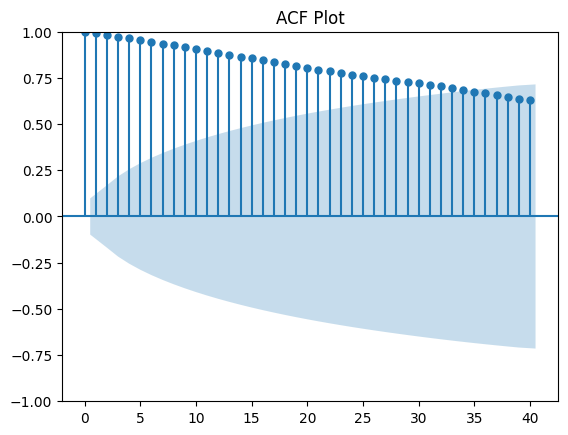

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(training_df, lags=40)
plt.title("ACF Plot")
plt.show()

**The plot generated above shows, the autocorrelation values decline slowly and do not cut off sharply. This shows that the data is not stationary. Let's go ahead and check if thats the case.**

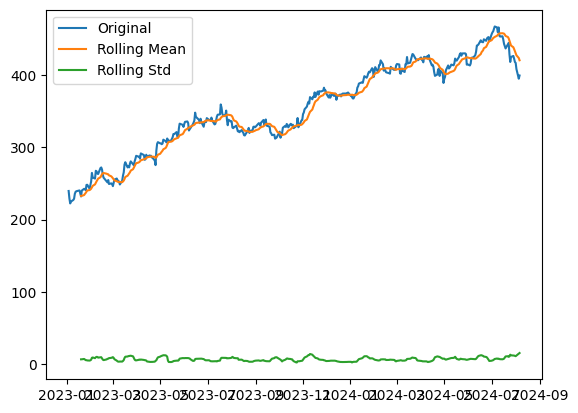

In [ ]:
#Plotting rolling statistics
window = 12
rolling_mean = training_df.rolling(window=window).mean()
rolling_std = training_df.rolling(window=window).std()

plt.plot(training_df, label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.show()


**Stationarity implies that both the mean and the variance should be constant over time and we can clearly see that this data has an upward trend.**

In [ ]:
train_data_diff = training_df['Close'].diff().dropna()

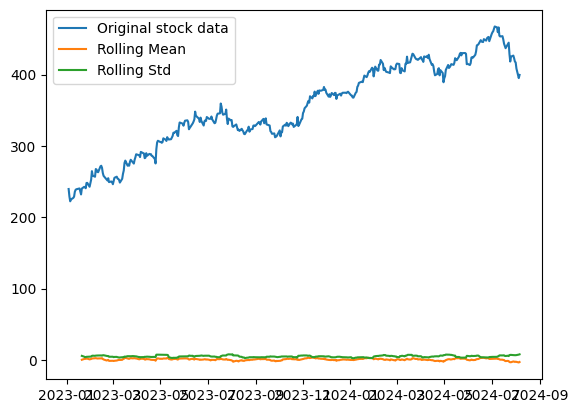

In [ ]:
window = 12
rolling_mean = train_data_diff.rolling(window=window).mean()
rolling_std = train_data_diff.rolling(window=window).std()

plt.plot(training_df, label='Original stock data')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.show()


**Now that the data is stationary,Let's again draw the ACF plot.**

<Figure size 1200x600 with 0 Axes>

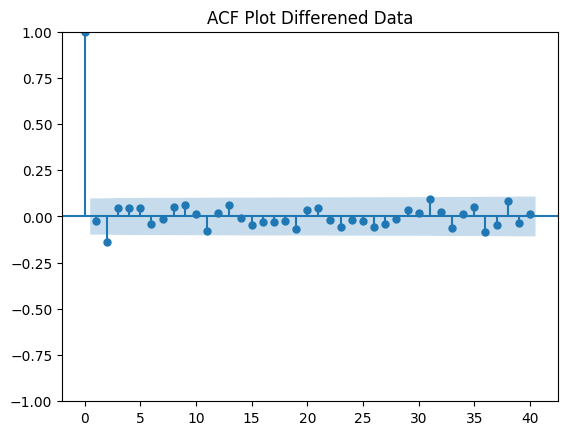

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(train_data_diff, lags=40)
plt.title("ACF Plot Differened Data")
plt.show()

**Since it looks like the moving average order may lie in range (0,5) lets draw a more fine graph**

<Figure size 1200x600 with 0 Axes>

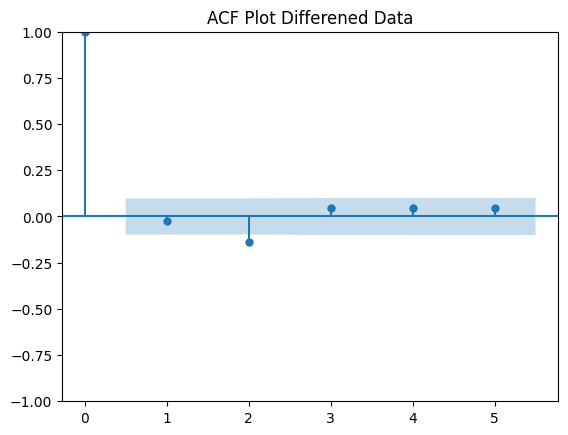

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(train_data_diff, lags=5)
plt.title("ACF Plot Differened Data")
plt.show()

<Figure size 1200x600 with 0 Axes>

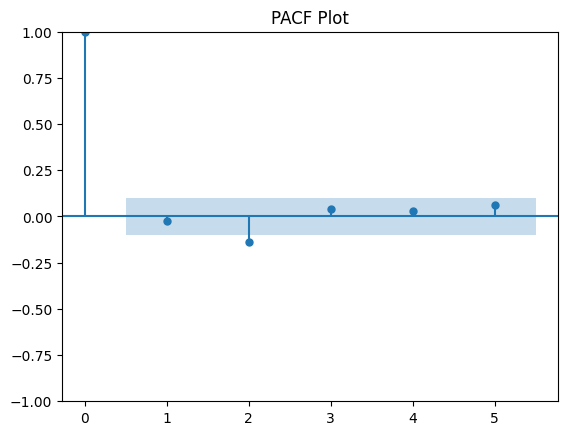

In [ ]:
plt.figure(figsize=(12, 6))
plot_pacf(train_data_diff, lags=5)
plt.title("PACF Plot")
plt.show()

**Now let's implement the grid search method for ARIMA model and I will restrict ranges to 5**

In [ ]:
def grid_search_arima(series, p_range, d_range, q_range):
    best_aic = np.inf
    best_order = None
    for p in p_range:
      for q in q_range:
        for d in d_range:
          model=ARIMA(series,order=(p,d,q)).fit()
          if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, d, q)
    return best_order


best_order = grid_search_arima(training_df, p_range=range(5), d_range=range(3), q_range=range(5))
print("Optimal ARIMA order:", best_order)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimal ARIMA order: (2, 2, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**The output is :- "Optimal ARIMA order: (2,2,1)", which completes our ARIMA model.**


In [ ]:
final_model=ARIMA(training_df,order=(2,2,1)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
print(final_model.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_MSFT   No. Observations:                  400
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1202.891
Date:                Mon, 30 Dec 2024   AIC                           2413.781
Time:                        17:45:20   BIC                           2429.727
Sample:                             0   HQIC                          2420.097
                                - 400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0304      0.048     -0.631      0.528      -0.125       0.064
ar.L2         -0.1427      0.052     -2.747      0.006      -0.245      -0.041
ma.L1         -0.9937      0.016    -60.984      0.0

# **Forecasting**

**Use the trained ARIMA model to forecast future values**

In [ ]:
forecast = final_model.forecast(steps=end-index)
y_points=np.array(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
x_points = testing_df.index.to_numpy()

In [ ]:
testing_df=testing_df['Close']
print(testing_df.shape)

(101, 1)


**Plot the actual vs. predicted values for the test dataset.**

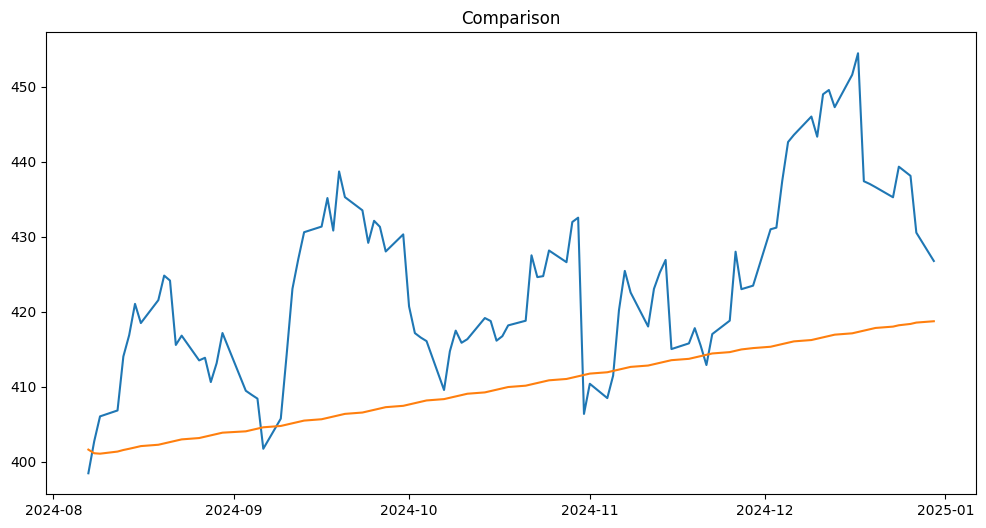

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(testing_df)
plt.plot(x_points,y_points)
plt.title("Comparison")
plt.show()

# **Model Evaluation**

**Evaluate the model using performance metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).**

In [ ]:
true_values=np.array(testing_df)

In [ ]:
mae = np.mean(np.abs(true_values - y_points))
mse = np.mean((true_values - y_points) ** 2)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 15.211121668047845
MSE: 357.3146748137205
RMSE: 18.902768972129994


# **Visualisation**

**Plot the time series data, the forecasted values, and the residuals of the ARIMA model.**

In [ ]:
residual=final_model.resid
print(residual)

Date
2023-01-03    239.580002
2023-01-04   -130.270339
2023-01-05      3.684037
2023-01-06     11.043424
2023-01-09      6.939390
                 ...    
2024-07-31     -4.868883
2024-08-01     -2.282786
2024-08-02     -9.655441
2024-08-05    -14.062249
2024-08-06      2.631535
Length: 400, dtype: float64


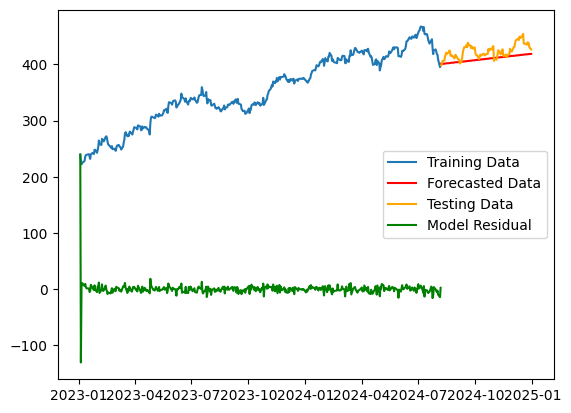

In [ ]:
plt.plot(training_df['Close'],label='Training Data')
plt.plot(x_points,y_points,color='red', label='Forecasted Data')
plt.plot(testing_df,color='orange',label='Testing Data')
plt.plot(residual,color='green',label='Model Residual')
plt.legend(loc='best')
plt.show()